In [1]:
# New version: FA 2023 Feb 5

# Predicting ages from spectroscopic abundances with XGBoost 

Using not only the Kepler data as training set, but all seismic+APOGEE data we have available

In [2]:
import numpy as np #numpy
import pandas as pd
import matplotlib.pyplot as plt  #matplotlib
import matplotlib.gridspec as gridspec
from matplotlib import colors
from matplotlib.colors import LogNorm
from matplotlib import patches
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.ticker import NullFormatter

import astropy.table  #astropy
from astropy.table import Table, Column, MaskedColumn 
from astropy.visualization import astropy_mpl_style
from scipy.stats import gaussian_kde  #scipy: science python
from scipy.interpolate import make_interp_spline

import os.path

from time import time

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as MSE

import xgboost as xgb
import shap

from itertools import product
import pickle
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

# Import the training table (APOGEE-Kepler dataset)

We use the table containing asteroseismic+spectroscopic age estimates from [Miglio et al. (2021)](https://ui.adsabs.harvard.edu/abs/2021A%26A...645A..85M/abstract) - crossmatched with APOGEE DR17:

In [3]:
miglio2021 = Table.read("../data/Miglio2021_X_APOGEE_DR17.fits")
names = [name for name in miglio2021.colnames if len(miglio2021[name].shape) <= 1]
miglio2021.keep_columns(names)
mig = miglio2021.to_pandas()
mig.head()

,APOGEE,KIC,Jmag,Hmag,Ksmag,RAdeg,DEdeg,__Fe_H_,__alpha_M_,Age,...,NI_FE_ERR,NI_FE_FLAG,CU_FE,CU_FE_SPEC,CU_FE_ERR,CU_FE_FLAG,CE_FE,CE_FE_SPEC,CE_FE_ERR,CE_FE_FLAG
0,b'2M19222920+3710285',1569842,9.589,9.074,8.989,290.6217,37.174599,-0.24,0.12,9.8,...,0.012334,0,NaN,NaN,0.005112,2,0.096240,0.151900,0.069591,0
1,b'2M19300513+3717470',1726291,11.206,10.679,10.547,292.5214,37.296398,-0.34,0.19,10.1,...,0.015864,0,NaN,NaN,0.009413,2,-0.318970,-0.263310,0.085400,0
2,b'2M19045380+3741230',2283721,11.266,10.709,10.590,286.2242,37.689701,-0.19,0.11,9.4,...,0.014437,0,NaN,NaN,NaN,259,0.116419,0.172079,0.077468,0
3,b'2M19060736+3740100',2284679,9.923,9.456,9.335,286.5307,37.669399,-0.45,0.21,11.2,...,0.014171,0,NaN,NaN,0.010622,2,-0.313170,-0.257510,0.076819,0
4,b'2M19280882+3736381',2305590,9.829,9.235,9.128,292.0368,37.610600,-0.30,0.24,10.2,...,0.018914,0,NaN,NaN,0.009991,258,0.581840,0.637500,0.082008,0


### Metal-poor stars: Montalbán+2021

In [4]:
montalban2021 = Table.read("../data/Montalban2021_X_APOGEE_DR17.fits")

In [5]:
montalban2021

KIC,_RAJ2000,_DEJ2000,group,n_modes,numax,numax_err,delta_nu,Teff_DR14,Teff_err_DR14,Fe_H_DR14,alpha_Fe_DR14,eccentricity,mass_16,mass,mass_84,radius_16,radius,radius_84,age_16,age,age_84,APOGEE_ID,TELESCOPE,FIELD,ALT_ID,RA,DEC,GLON,GLAT,J,J_ERR,H,H_ERR,K,K_ERR,AK_TARG,AK_TARG_METHOD,AK_WISE,SFD_EBV,APOGEE_TARGET1,APOGEE_TARGET2,APOGEE2_TARGET1,APOGEE2_TARGET2,APOGEE2_TARGET3,APOGEE2_TARGET4,TARGFLAGS,SURVEY,PROGRAMNAME,NVISITS,SNR,SNREV,STARFLAG,STARFLAGS,ANDFLAG,ANDFLAGS,VHELIO_AVG,VSCATTER,VERR,RV_TEFF,RV_LOGG,RV_FEH,RV_ALPHA,RV_CARB,RV_CHI2,RV_CCFWHM,RV_AUTOFWHM,RV_FLAG,N_COMPONENTS,MEANFIB,SIGFIB,MIN_H,MAX_H,MIN_JK,MAX_JK,GAIAEDR3_SOURCE_ID,GAIAEDR3_PARALLAX,GAIAEDR3_PARALLAX_ERROR,GAIAEDR3_PMRA,GAIAEDR3_PMRA_ERROR,GAIAEDR3_PMDEC,GAIAEDR3_PMDEC_ERROR,GAIAEDR3_PHOT_G_MEAN_MAG,GAIAEDR3_PHOT_BP_MEAN_MAG,GAIAEDR3_PHOT_RP_MEAN_MAG,GAIAEDR3_DR2_RADIAL_VELOCITY,GAIAEDR3_DR2_RADIAL_VELOCITY_ERROR,GAIAEDR3_R_MED_GEO,GAIAEDR3_R_LO_GEO,GAIAEDR3_R_HI_GEO,GAIAEDR3_R_MED_PHOTOGEO,GAIAEDR3_R_LO_PHOTOGEO,GAIAEDR3_R_HI_PHOTOGEO,ASPCAP_GRID,ASPCAP_CHI2,PARAMFLAG,ASPCAPFLAG,ASPCAPFLAGS,FRAC_BADPIX,FRAC_LOWSNR,FRAC_SIGSKY,X_H,X_H_ERR,X_M,X_M_ERR,ELEM_CHI2,ELEMFRAC,EXTRATARG,MEMBERFLAG,MEMBER,X_H_SPEC,X_M_SPEC,TEFF,TEFF_ERR,LOGG,LOGG_ERR,M_H,M_H_ERR,ALPHA_M,ALPHA_M_ERR,VMICRO,VMACRO,VSINI,TEFF_SPEC,LOGG_SPEC,C_FE,C_FE_SPEC,C_FE_ERR,C_FE_FLAG,CI_FE,CI_FE_SPEC,CI_FE_ERR,CI_FE_FLAG,N_FE,N_FE_SPEC,N_FE_ERR,N_FE_FLAG,O_FE,O_FE_SPEC,O_FE_ERR,O_FE_FLAG,NA_FE,NA_FE_SPEC,NA_FE_ERR,NA_FE_FLAG,MG_FE,MG_FE_SPEC,MG_FE_ERR,MG_FE_FLAG,AL_FE,AL_FE_SPEC,AL_FE_ERR,AL_FE_FLAG,SI_FE,SI_FE_SPEC,SI_FE_ERR,SI_FE_FLAG,P_FE,P_FE_SPEC,P_FE_ERR,P_FE_FLAG,S_FE,S_FE_SPEC,S_FE_ERR,S_FE_FLAG,K_FE,K_FE_SPEC,K_FE_ERR,K_FE_FLAG,CA_FE,CA_FE_SPEC,CA_FE_ERR,CA_FE_FLAG,TI_FE,TI_FE_SPEC,TI_FE_ERR,TI_FE_FLAG,TIII_FE,TIII_FE_SPEC,TIII_FE_ERR,TIII_FE_FLAG,V_FE,V_FE_SPEC,V_FE_ERR,V_FE_FLAG,CR_FE,CR_FE_SPEC,CR_FE_ERR,CR_FE_FLAG,MN_FE,MN_FE_SPEC,MN_FE_ERR,MN_FE_FLAG,FE_H,FE_H_SPEC,FE_H_ERR,FE_H_FLAG,CO_FE,CO_FE_SPEC,CO_FE_ERR,CO_FE_FLAG,NI_FE,NI_FE_SPEC,NI_FE_ERR,NI_FE_FLAG,CU_FE,CU_FE_SPEC,CU_FE_ERR,CU_FE_FLAG,CE_FE,CE_FE_SPEC,CE_FE_ERR,CE_FE_FLAG,Separation
,deg,deg,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,arcsec
int32,float64,float64,bytes1,int16,float32,float32,float32,int16,int16,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,bytes30,bytes6,bytes20,bytes30,float64,float64,float64,float64,float32,float32,float32,float32,float32,float32,float32,bytes32,float32,float32,int32,int32,int32,int32,int32,int32,bytes132,bytes32,bytes32,int32,float32,float32,int64,bytes132,int64,bytes132,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,int32,float32,float32,float32,float32,float32,float32,int64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,bytes8,float32,int64[9],int64,bytes256,float32,float32,float32,float32[27],float32[27],float32[27],float32[27],float32[27],float32[27],int32,int64,bytes10,float32[27],float32[27],float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,float32,float32,float32,int32,float32,float32,float32,int32,float32,float32,float32,int32,float32,float32,float32,int32,float32,float32,float32,int32,float32,float32,float32,int32,float32,float32,float32,int32,float32,float32,float32,int32,float32,float32,float32,int32,float32,float32,float32,int32,float32,float32,float32,int32,float32,float32,float32,int32,float32,float32,float32,int32,float32,float32,float32,int32,float32,float32,float32,int32,float32,float32,float32,int32,float32,float32,float32,int32,float32,float32,float32,int32,float32,float32,float32,int32,float32,float32,float32,int32,float32,flo

## Data selection criteria

Looking at the FLAG values above, we decide not to use [P/Fe] and [Cu/Fe].
For all other abundances, we require the corresponding FLAG to equal zero:

In [6]:
mig = mig[(mig['RV_FLAG'] == 0)   & (mig['C_FE_FLAG'] == 0)   & \
          (mig['CI_FE_FLAG'] == 0)& (mig['N_FE_FLAG'] == 0)   & \
          (mig['O_FE_FLAG'] == 0) & (mig['NA_FE_FLAG'] == 0)  & \
          (mig['S_FE_FLAG'] == 0) & (mig['TIII_FE_FLAG'] == 0)& \
          (mig['V_FE_FLAG'] == 0) & (mig['CE_FE_FLAG'] == 0)]

In [7]:
print(len(mig), "suffice the FLAG conditions")

3250 suffice the FLAG conditions


## Some plots (overplotting the training set over the full APOGEE DR17 data):

The APOGEE DR17 allStar file is big, so it's not included in the data folder. Even the "light" version is 1.7 GB:
* Data model: https://data.sdss.org/datamodel/files/APOGEE_ASPCAP/APRED_VERS/ASPCAP_VERS/allStar.html
* "Lite" file for download: https://data.sdss.org/sas/dr17/apogee/spectro/aspcap/dr17/synspec_rev1/allStarLite-dr17-synspec_rev1.fits

The following cell reads the DR17 table:

In [106]:
apogee_data = "../data/allStarLite-dr17-synspec_rev1.fits"

if os.path.exists(apogee_data):
    pass
else:
    # Download the APOGEE DR17 "lite" version: (this can take a while...)
    os.system('wget https://data.sdss.org/sas/dr17/apogee/spectro/aspcap/dr17/synspec_rev1/allStarLite-dr17-synspec_rev1.fits')
    os.system('mv allStarLite-dr17-synspec_rev1.fits ../data/.')

# Read and convert to pandas
apogee_dr17 = Table.read(apogee_data)
names = [name for name in apogee_dr17.colnames if len(apogee_dr17[name].shape) <= 1]
apogee_dr17.keep_columns(names)
big   = apogee_dr17.to_pandas()

print('Number of rows: ' +str(len(big)))
big.head()

Number of rows: 733901


,APOGEE_ID,TELESCOPE,FIELD,ALT_ID,RA,DEC,GLON,GLAT,J,J_ERR,...,NI_FE_ERR,NI_FE_FLAG,CU_FE,CU_FE_SPEC,CU_FE_ERR,CU_FE_FLAG,CE_FE,CE_FE_SPEC,CE_FE_ERR,CE_FE_FLAG
0,b'VESTA',b'apo1m',b'calibration',b' ',NaN,NaN,292.219131,-30.602919,99.999001,0.000,...,0.010266,0,NaN,NaN,0.059403,2,NaN,NaN,NaN,64
1,b'2M00000002+7417074',b'apo25m',b'120+12',b'none',0.000103,74.285408,119.401807,11.767414,8.597000,0.039,...,0.010609,0,NaN,NaN,0.001221,2,NaN,NaN,NaN,64
2,b'2M00000019-1924498',b'apo25m',b'060-75',b'none',0.000832,-19.413851,63.394122,-75.906397,11.074000,0.022,...,0.013835,0,NaN,NaN,0.102594,2,NaN,NaN,NaN,64
3,b'2M00000032+5737103',b'apo25m',b'116-04',b'none',0.001335,57.619530,116.065371,-4.564768,10.905000,0.023,...,0.016555,0,NaN,NaN,0.123839,2,NaN,NaN,NaN,64
4,b'2M00000032+5737103',b'apo25m',b'N7789',b'none',0.001335,57.619530,116.065371,-4.564768,10.905000,0.023,...,0.012638,0,NaN,NaN,0.107103,2,NaN,NaN,NaN,64


### $T_{\rm eff}-\log g$ diagram

In [107]:
dr17_master = Table.read("/home/friedel/Astro/Spectro/APOGEE/data/DR17/APOGEE_DR17_MASTER_Feb2023.fits")
chem_age = np.isfinite(dr17_master['spec_age_feb2023'])

In [108]:
# Cut out stars on the RGB
kielbox =  (big['LOGG'] >  7.2 - 0.0011*big['TEFF'])  & (big['LOGG'] <  9.0-0.0011*big['TEFF']) & \
           (big['LOGG'] < -6.8 + 0.0022*big['TEFF'])  & (big['LOGG'] > -8.8+0.0022*big['TEFF'])

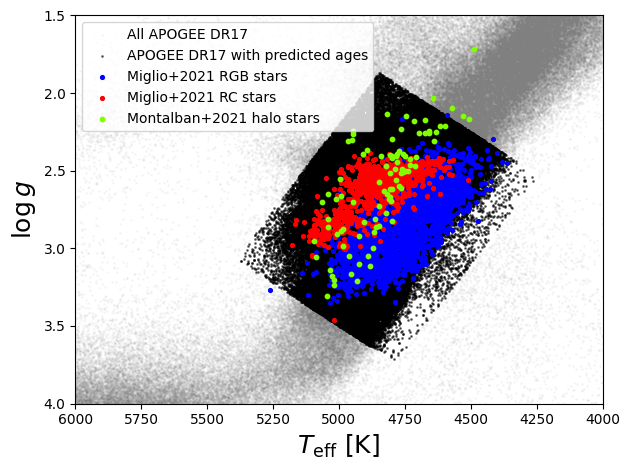

In [162]:
rgb = (mig['evstate']==1)
rc  = (mig['evstate']==2)

plt.scatter(big['TEFF'], big['LOGG'], c="grey", alpha=0.05, s=1, label="All APOGEE DR17")
plt.scatter(big['TEFF'][kielbox], big['LOGG'][kielbox], c="k", s=1, label="APOGEE DR17 with predicted ages", alpha=0.5)
plt.scatter(mig['TEFF'][rgb], mig['LOGG'][rgb], s=7.5, c="b", label="Miglio+2021 RGB stars")
plt.scatter(mig['TEFF'][rc],  mig['LOGG'][rc],  s=7.5, c="red", label="Miglio+2021 RC stars")
plt.scatter(montalban2021['TEFF'],  montalban2021['LOGG'],  s=10, c="chartreuse", label="Montalban+2021 halo stars")
plt.axis([6000, 4000, 4, 1.5])
plt.xlabel(r"$T_{\rm eff}$ [K]", fontsize=18)
plt.ylabel(r"$\log g$", fontsize=18)
plt.legend(loc="upper left")

xx = np.linspace(4000,6000,100)
"""plt.plot(xx, 7-0.0011*xx)
plt.plot(xx, 9.2-0.0011*xx)
plt.plot(xx, -6.8+0.0022*xx)
plt.plot(xx, -8.8+0.0022*xx)"""
plt.tight_layout()
plt.savefig("../im/kiel_diagram2.png")

### Age uncertainties of the Miglio+2021 sample

Median rel. age uncertainty for RGB: 0.22727275
Median rel. age uncertainty for RC: 0.097561


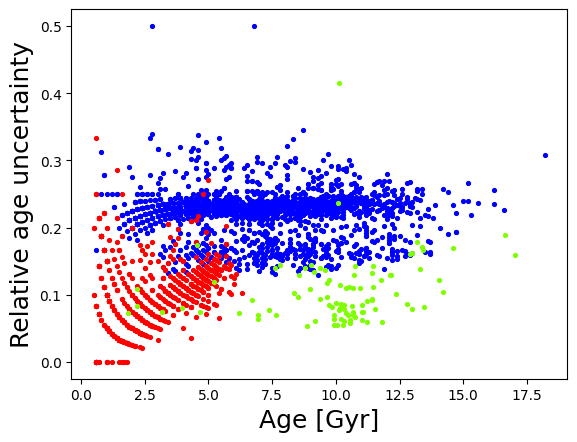

In [164]:
x = mig['Age']
y = 0.5 * (mig['b_age_lc'] - mig['b_Age']) / mig["Age"]

plt.scatter(x[rgb],y[rgb], c="b", s=7.5)
plt.scatter(x[rc], y[rc],  c="r", s=7.5)
plt.scatter(montalban2021["age"], 0.5*(montalban2021["age_84"]-montalban2021["age_16"])/montalban2021["age"], 
            c="chartreuse", s=7.5)

plt.xlabel(r"Age [Gyr]", fontsize=18)
plt.ylabel(r"Relative age uncertainty", fontsize=18)
plt.savefig("../im/age_uncerts_training.png")

print("Median rel. age uncertainty for RGB:", np.nanmedian(y[rgb]))
print("Median rel. age uncertainty for RC:", np.nanmedian(y[rc]))
      

In [157]:
montalban2021["Zg"] = np.sin(montalban2021["GLAT"]*np.pi/180.) * montalban2021["GAIAEDR3_R_MED_PHOTOGEO"] / 1000.
montalban2021["Xg"] = np.cos(montalban2021["GLAT"]*np.pi/180.) * np.cos(montalban2021["GLON"]*np.pi/180.) * montalban2021["GAIAEDR3_R_MED_PHOTOGEO"] / 1000. -8.2
montalban2021["Yg"] = np.cos(montalban2021["GLAT"]*np.pi/180.) * np.sin(montalban2021["GLON"]*np.pi/180.) * montalban2021["GAIAEDR3_R_MED_PHOTOGEO"] / 1000.
montalban2021["Rg"] = np.sqrt(montalban2021["Xg"]**2. + montalban2021["Yg"]**2.)

## Galactic distribution

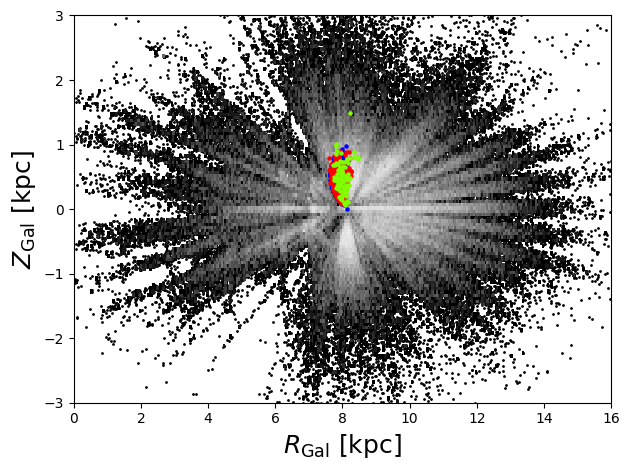

In [165]:
#plt.scatter(dr17_master['Rg'], dr17_master['Zg'], c="grey", alpha=0.05, s=1, label="APOGEE DR17")
plt.scatter(dr17_master['Rg'][chem_age], dr17_master['Zg'][chem_age], c="k", s=1, alpha=1, label="APOGEE DR17")
Ht,X1,X2 = np.histogram2d(dr17_master['Rg'][chem_age], dr17_master['Zg'][chem_age], 
                          bins=[320,120], range=[[0, 16], [-3, 3]])
Ht[Ht<2] = np.nan
image = plt.pcolor(0.5*(X1[:-1]+X1[1:]), 0.5*(X2[:-1]+X2[1:]), Ht.T, cmap="Greys_r", 
                   label=r"APOGEE DR17 giants", norm=colors.LogNorm())

plt.scatter(mig['GalR'][rgb], mig['GalZ'][rgb], s=5, c="b", label="Miglio+2021 RGB stars")
plt.scatter(mig['GalR'][rc],  mig['GalZ'][rc],  s=5, c="red", label="Miglio+2021 RC stars")
plt.scatter(montalban2021["Rg"],  montalban2021["Zg"],  s=5, c="chartreuse", label="Montalbán+2021 stars")
plt.axis([0, 16, -3, 3])
plt.xlabel(r"$R_{\rm Gal}$ [kpc]", fontsize=18)
plt.ylabel(r"$Z_{\rm Gal}$ [kpc]", fontsize=18)
plt.tight_layout()
plt.savefig("../im/RZ_training_vs_all2.png")

# Create the actual training set

Now we create a pandas dataframe containing only the columns we think could be interesting to use in the training:

In [33]:
# bring the Montalban table to pandas
montalban2021["Age"] = montalban2021["age"]
names = [name for name in montalban2021.colnames if len(montalban2021[name].shape) <= 1]
montalban2021.keep_columns(names)
mon = montalban2021.to_pandas()
# relevant columns:
columns =         ['Age',   'TEFF',  'LOGG', 
                   'C_FE',  'CI_FE', 'N_FE', 'O_FE', 
                   'NA_FE', 'MG_FE', 'AL_FE', 'K_FE', 
                   'CA_FE', 'TI_FE', 'V_FE', 'MN_FE', 
                   'CO_FE', 'NI_FE' ]
# stack Miglio+2021 & Montalban+2021
filtered_df = pd.concat([mig[columns], mon[columns]])

filtered_df = filtered_df.dropna()
filtered_df = filtered_df.apply(pd.to_numeric, errors='coerce')
filtered_df.head()

,Age,TEFF,LOGG,C_FE,CI_FE,N_FE,O_FE,NA_FE,MG_FE,AL_FE,K_FE,CA_FE,TI_FE,V_FE,MN_FE,CO_FE,NI_FE
0,9.8,4817.990723,3.083905,0.071996,0.076009,0.073346,0.196913,-0.129988,0.223263,0.188314,0.235769,0.094765,0.179623,-0.042288,-0.101498,0.09864,0.107133
1,10.1,4823.796387,3.109932,0.070293,0.194000,0.115990,0.314393,-0.352128,0.348673,0.259540,0.302629,0.190765,0.151823,0.250612,-0.122728,0.13715,0.110182
2,9.4,4748.026855,2.788529,0.065446,0.029532,0.086760,0.180403,0.009112,0.186943,0.195936,0.368155,0.109715,0.109363,-0.187218,-0.096728,0.11898,0.042022
3,11.2,4889.548828,3.245908,0.102185,0.198900,0.009152,0.328173,0.068522,0.361593,0.247761,0.361549,0.191585,0.183673,-0.175608,-0.144048,0.08713,0.081733
4,10.2,4605.007812,2.480893,0.166720,0.234920,0.034750,0.282853,0.043942,0.394983,0.272437,0.411468,0.190875,0.281993,-0.025298,-0.137478,0.19849,0.095583


In [34]:
# Split dataframe into input and output columns
y = filtered_df['Age']
X = filtered_df.drop(columns = 'Age')

# Splitting into train and test (80% vs 20%)
train_X, test_X, train_y, test_y = train_test_split(X, y,
                                                    test_size = 0.2, 
                                                    random_state = 42)

# Train XGBoost

Test if the algorithm works - this should be really fast:

In [35]:
filename = './models/test_model2.pkl'

if os.path.exists(filename):
    # Read the trained model from disk:
    model = pickle.load(open(filename, 'rb'))
else:
    # Instantiation
    model = xgb.XGBRegressor(objective ='reg:squarederror',
                             n_estimators = 10, seed = 123)
    # Fit the model
    model.fit(train_X, train_y)
    # Save the model
    pickle.dump(model, open(filename, 'wb'))

# Predict the model
pred = model.predict(test_X)
  
# RMSE Computation
rmse = np.sqrt(MSE(test_y, pred))
print("RMSE : % f" %(rmse))

#Score
result = model.score(test_X, test_y)
print("Score: "+str(result))

RMSE :  1.432190
Score: 0.8291089297209744


### Run gridsearch to optimise the hyperparameters:
Running the following cell takes a while (~30 min on an 8-core computer with 16GB RAM)... so it's not recommended to run it unless you really need it.

In [50]:
from sklearn.model_selection import GridSearchCV


xgb1 = xgb.XGBRegressor()
parameters = {
    'nthread':[4],
    'objective':['reg:squarederror', 'reg:pseudohubererror'],
    'learning_rate':[0.005, 0.01, 0.02, 0.03],
    'max_depth':[4, 5, 6, 7],
    'min_child_weight': [4,5,6],
    'subsample':[0.6, 0.7],
    'n_estimators':[500, 750, 1000]
}
xgb_grid = GridSearchCV(xgb1,
                        parameters,
                        cv=2,
                        n_jobs=2,
                        verbose=True)
xgb_grid.fit(train_X,
             train_y)


Fitting 2 folds for each of 576 candidates, totalling 1152 fits


GridSearchCV(cv=2,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None, gpu_id=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    monotone_constraints=None, n_estimators=100,
                                    n_jobs=None, num_parallel_tree=None,
                                    predictor=None, random_state=None, ...),
             n_jobs=2,
             param_grid={'learning_rate': [0.005, 0.01, 0.02, 0.03],
                         'max_depth': [4, 5, 6, 7],
                         'min_child_weight': [4, 5, 6],
                         'n_estimators': [500, 750, 1000], 'nthread': [4],
                         'objective': ['reg:squarederror',
                                       'reg:pseudohubererror'],
                         'subsample': [0.6, 0.7]},
             verbose=True)

In [51]:
xgb_grid.best_params_

{'learning_rate': 0.005,
 'max_depth': 7,
 'min_child_weight': 5,
 'n_estimators': 750,
 'nthread': 4,
 'objective': 'reg:pseudohubererror',
 'subsample': 0.6}

### Run the algorithm with optised hyperparameters:

In [53]:
filename = './models/migliomontalban_model.pkl'

if os.path.exists(filename):
    # Read the trained model from disk:
    model = pickle.load(open(filename, 'rb'))
else:
    # Instantiation
    model = xgb.XGBRegressor(objective ='reg:pseudohubererror', 
                             n_estimators = 750, learning_rate = 0.005,
                             max_depth = 7, min_child_weight = 5, 
                             subsample = 0.6, seed = 123)
    # Fit the model
    model.fit(train_X, train_y)
    # Save the model
    pickle.dump(model, open(filename, 'wb'))

# Predict the model
pred = model.predict(test_X)
  
# RMSE Computation
rmse = np.sqrt(MSE(test_y, pred))
print("RMSE : % f" %(rmse))

#Score
result = model.score(test_X, test_y)
print("Score: "+str(result))

RMSE :  1.314675
Score: 0.8560025866277963


# Plots

In [54]:
def running_median(X, Y, nbins=10):
    bins = np.linspace(np.nanquantile(X, 0.005),np.nanquantile(X, 0.995), nbins)
    delta = bins[1]-bins[0]
    idx  = np.digitize(X, bins, right=False)
    med = [np.nanquantile(Y[idx==k], 0.5) for k in range(1, nbins)]
    q16 = [np.nanquantile(Y[idx==k], 0.16) for k in range(1, nbins)]
    q84 = [np.nanquantile(Y[idx==k], 0.84) for k in range(1, nbins)]
    return bins[1:] - delta/2, med, q16, q84

# Overplot running median
def overplot_trend(X, Y, alpha=0.2, color="k", bins=10, label=""):
    #lines = mdline(X, Y, bins=bins)
    lines = running_median(X, Y, nbins=bins)
    xnew  = np.linspace(lines[0].min(), lines[0].max(), bins)
    spl   = make_interp_spline(lines[0], lines[1], k=2)
    power_smooth = spl(xnew)
    plt.plot(lines[0], lines[1], ms=50, color=color, lw=3, label=label)
    plt.fill_between(lines[0], lines[2], lines[3], alpha=alpha, color=color)

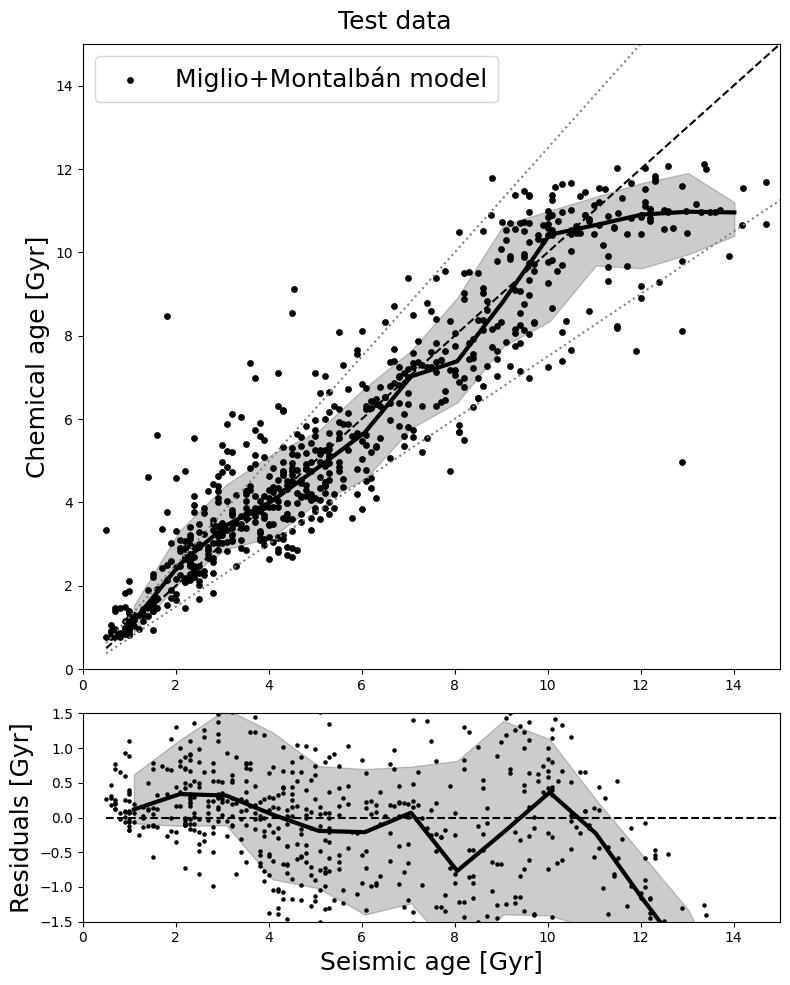

In [57]:
f, (a0, a1) = plt.subplots(2, 1, height_ratios=[3, 1], figsize=(8,10))

# Top panel: predicted age vs. seismic age
plt.axes(a0)
a0.scatter(test_y, pred, c="k", s=15, label="Miglio+Montalbán model")
overplot_trend(test_y, pred, alpha=0.2, color="k", bins=15)
xx = np.linspace(np.min(test_y), np.max(test_y), 20)
a0.plot(xx, xx, color = 'k', ls="dashed")
a0.plot(xx, 1.25*xx, color = 'grey', ls="dotted")
a0.plot(xx, 0.75*xx, color = 'grey', ls="dotted")
a0.set_ylabel(r"Chemical age [Gyr]", fontsize=18)
a0.legend(loc="upper left", fontsize=18)
a0.axis([0,15,0,15])

# Bottom panel: residuals
plt.axes(a1)
a1.scatter(test_y, pred-test_y, c="k", s=5)
overplot_trend(test_y, pred-test_y, alpha=0.2, color="k", bins=15)
if plot_rgb_rc:
    a1.scatter(test_rgb, pred_rgb-test_rgb, c="b", s=5)
    a1.scatter(test_rc,  pred_rc-test_rc, c="r", s=5)
a1.plot(xx, np.zeros(len(xx)), color = 'k', ls="dashed")
a1.set_xlabel(r"Seismic age [Gyr]", fontsize=18)
a1.set_ylabel(r"Residuals [Gyr]", fontsize=18)

a1.axis([0,15,-1.5, 1.5])
plt.suptitle("Test data", fontsize=18)
plt.tight_layout()
plt.savefig("../im/predicted_vs_true_testdata2.png")

# SHAP

ntree_limit is deprecated, use `iteration_range` or model slicing instead.
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


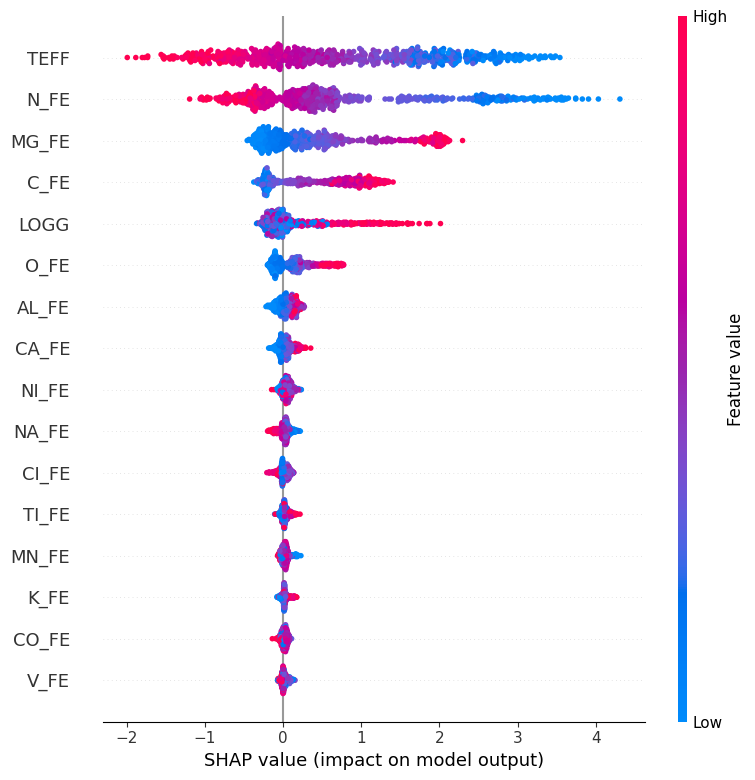

In [58]:
# Fits the explainer
explainer = shap.Explainer(model)
# Calculates the SHAP values - It might take some time
shap_values = explainer(test_X)
shap.summary_plot(shap_values, test_X, show=False)
# Same as
#shap.plots.beeswarm(shap_values)
plt.savefig("../im/shap_beeswarm.png")

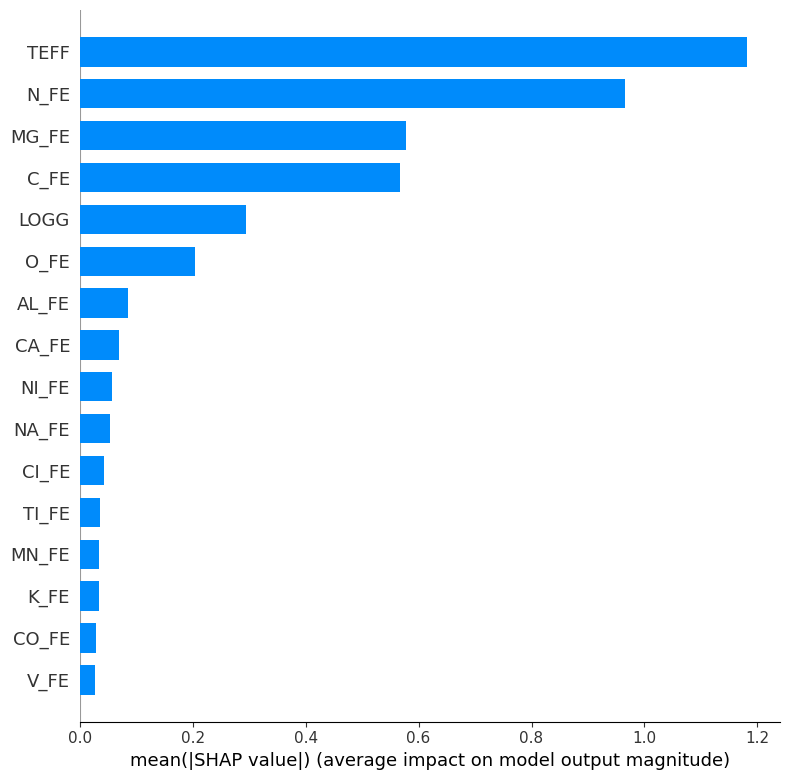

In [59]:
shap.summary_plot(shap_values, test_X, plot_type="bar")

# Estimate ages for the APOGEE DR17 data:

We already read the big file above:

In [86]:
big.head()

,APOGEE_ID,TELESCOPE,FIELD,ALT_ID,RA,DEC,GLON,GLAT,J,J_ERR,...,NI_FE_ERR,NI_FE_FLAG,CU_FE,CU_FE_SPEC,CU_FE_ERR,CU_FE_FLAG,CE_FE,CE_FE_SPEC,CE_FE_ERR,CE_FE_FLAG
0,b'VESTA',b'apo1m',b'calibration',b' ',NaN,NaN,292.219131,-30.602919,99.999001,0.000,...,0.010266,0,NaN,NaN,0.059403,2,NaN,NaN,NaN,64
1,b'2M00000002+7417074',b'apo25m',b'120+12',b'none',0.000103,74.285408,119.401807,11.767414,8.597000,0.039,...,0.010609,0,NaN,NaN,0.001221,2,NaN,NaN,NaN,64
2,b'2M00000019-1924498',b'apo25m',b'060-75',b'none',0.000832,-19.413851,63.394122,-75.906397,11.074000,0.022,...,0.013835,0,NaN,NaN,0.102594,2,NaN,NaN,NaN,64
3,b'2M00000032+5737103',b'apo25m',b'116-04',b'none',0.001335,57.619530,116.065371,-4.564768,10.905000,0.023,...,0.016555,0,NaN,NaN,0.123839,2,NaN,NaN,NaN,64
4,b'2M00000032+5737103',b'apo25m',b'N7789',b'none',0.001335,57.619530,116.065371,-4.564768,10.905000,0.023,...,0.012638,0,NaN,NaN,0.107103,2,NaN,NaN,NaN,64


Now let's cut out the sample we wish to calculate ages for - and apply the XGBoost model:

In [87]:
# For the method to work, we require good measurements for the main features 
#  {[C/Fe], Teff, [N/Fe], [Mg/Fe], log g}
selection = kielbox  & \
            (big['TEFF_ERR'] < 150) & (big['RV_FLAG'] == 0)    & \
            (big['C_FE_FLAG'] == 0) & (big['N_FE_FLAG'] == 0) & \
            (big['CI_FE_FLAG'] == 0)& (big['O_FE_FLAG'] == 0)  & \
            (big['TI_FE_FLAG'] == 0)& (big['CA_FE_FLAG'] == 0)  & \
            (big['AL_FE_FLAG'] == 0)& (big['CO_FE_FLAG'] == 0)  & \
            (big['NI_FE_FLAG'] == 0)& (big['MN_FE_FLAG'] == 0)
big = big[selection]
big = big.set_index('APOGEE_ID')

Now filter the necessary columns:

In [88]:
features = ['TEFF', 'LOGG', 
            'C_FE',  'CI_FE', 'N_FE', 'O_FE', 
            'NA_FE', 'MG_FE', 'AL_FE', 'K_FE', 
            'CA_FE', 'TI_FE', 'V_FE', 'MN_FE', 
            'CO_FE', 'NI_FE']

filtered_big = big[features].copy()
filtered_big = filtered_big.dropna()
filtered_big = filtered_big.apply(pd.to_numeric, errors='coerce')

print(len(filtered_big), "stars will be used")

205706 stars will be used


Use the model to infer the age:

In [89]:
pred_big = model.predict(filtered_big)

### Save the results as a table

In [90]:
save_big = filtered_big.copy()
save_big["spec_age_migliomontalban_feb2023"] = np.round(pred_big, 2)
save_big = save_big.drop(columns=features)

### Add columns describing the bias and statistical uncertainties 

To do this, we use the comparison with the test sample from above (but now showing the residuals as a function of estimated age):

In [91]:
agebins, med, q16, q84 = running_median(pred, test_y-pred, nbins=20)

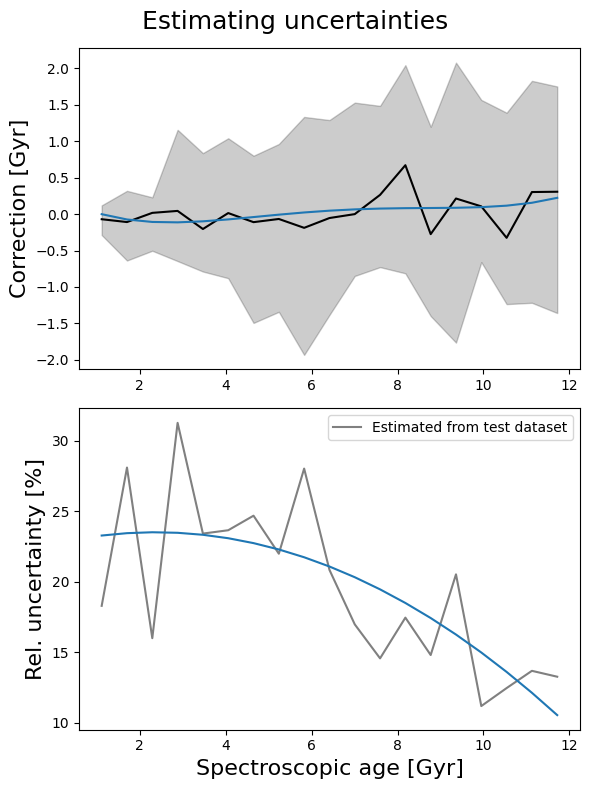

In [167]:
f, (a0, a1) = plt.subplots(2, 1, height_ratios=[1, 1], figsize=(6,8))

plt.axes(a0)
plt.plot(agebins, med, color="k")
plt.fill_between(agebins, q84, q16, alpha=.2, color="k")
med_fit = np.polyfit(agebins, med, 4)
p1 = np.poly1d(med_fit)
plt.plot(agebins, p1(agebins))
plt.ylabel(r"Correction [Gyr]", fontsize=16)

plt.axes(a1)
uncert = 50.*(np.array(q84)-np.array(q16)) / np.array(agebins)
plt.plot(agebins, uncert, color="grey", label="Estimated from test dataset")
unc_fit = np.polyfit(agebins, uncert, 2)
p2 = np.poly1d(unc_fit)
plt.plot(agebins, p2(agebins))
plt.xlabel(r"Spectroscopic age [Gyr]", fontsize=16)
plt.ylabel(r"Rel. uncertainty [%]", fontsize=16)
plt.legend(loc="upper right")
plt.suptitle(r"Estimating uncertainties", fontsize=18)
plt.tight_layout()
plt.savefig("../im/estimating_uncertainties2.png")

In [93]:
save_big["spec_age_migliomontalban_feb2023_calib"]  = np.round(pred_big + p1(pred_big), 2)
save_big["spec_age_migliomontalban_feb2023_uncert"] = np.round(0.01 * p2(pred_big) * pred_big, 2)

In [94]:
save_big

,spec_age_migliomontalban_feb2023,spec_age_migliomontalban_feb2023_calib,spec_age_migliomontalban_feb2023_uncert
APOGEE_ID,,,
b'2M00000068+5710233',6.66,6.72,1.38
b'2M00000133+5721163',3.76,3.68,0.87
b'2M00000211+6327470',3.62,3.52,0.84
b'2M00000222+5625359',5.55,5.56,1.22
b'2M00000446+5854329',4.01,3.94,0.93
...,...,...,...
b'2M23595553+6339020',1.06,1.06,0.25
b'2M23595669+6131251',2.70,2.59,0.63
b'2M23595837+5700444',3.83,3.75,0.89


In [95]:
save_big.to_csv("../data/spec_ages_migliomontalban_feb2023.csv")